# Bond Yield Exploratory Notebook

### Standard Imports

In [24]:
from dotenv import load_dotenv
import os
import pandas as pd
import requests
import matplotlib.pyplot as plt

In [25]:
load_dotenv()

True

Use your own API key to obtain your FRED data.

In [26]:
API_KEY = os.getenv("FRED_API_KEY")

## Functions

This function is to pull 

In [31]:
def fred_series(series_id: str, start="1960-01-01") -> pd.DataFrame:
    url = "https://api.stlouisfed.org/fred/series/observations"
    params = {
        "series_id": series_id,
        "api_key": API_KEY,
        "file_type": "json",
        "observation_start": start
    }
    r = requests.get(url, params=params)
    r.raise_for_status()
    #only the observations and no meta-data from the json
    obs = r.json()["observations"]

    df = pd.DataFrame({
        "date": [o["date"] for o in obs],
        series_id: [None if o["value"] == "." else float(o["value"]) for o in obs]
    })
    df["date"] = pd.to_datetime(df["date"])
    return df

Function to extract an individual FRED series

In [28]:
def fred_series(series_id: str, start) -> pd.DataFrame:
    url = "https://api.stlouisfed.org/fred/series/observations"
    params = {
        "series_id": series_id,
        "api_key": API_KEY,
        "file_type": "json",
        "observation_start": start
    }
    r = requests.get(url, params=params)
    r.raise_for_status()
    obs = r.json()["observations"]

    df = pd.DataFrame({
        "date": [o["date"] for o in obs],
        series_id: [None if o["value"] == "." else float(o["value"]) for o in obs]
    })
    df["date"] = pd.to_datetime(df["date"])
    return df


## Yield Curve Comparison 2 Year vs 10 Year

In [32]:
dgs2 = fred_series("DGS2")    # 2-Year
dgs10 = fred_series("DGS10")  # 10-Year

yields_df = pd.merge(dgs2, dgs10, on="date", how="inner").sort_values("date")
yields_df.tail()

,date,DGS2,DGS10
12857,2025-09-11,3.52,4.01
12858,2025-09-12,3.56,4.06
12859,2025-09-15,3.54,4.05
12860,2025-09-16,3.51,4.04
12861,2025-09-17,3.52,4.06


In [33]:
yields_df.index

RangeIndex(start=0, stop=12862, step=1)

In [34]:
yields_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12862 entries, 0 to 12861
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    12862 non-null  datetime64[ns]
 1   DGS2    12321 non-null  float64       
 2   DGS10   12321 non-null  float64       
dtypes: datetime64[ns](1), float64(2)
memory usage: 301.6 KB


Plots for historical two, ten, and yield curve spread.

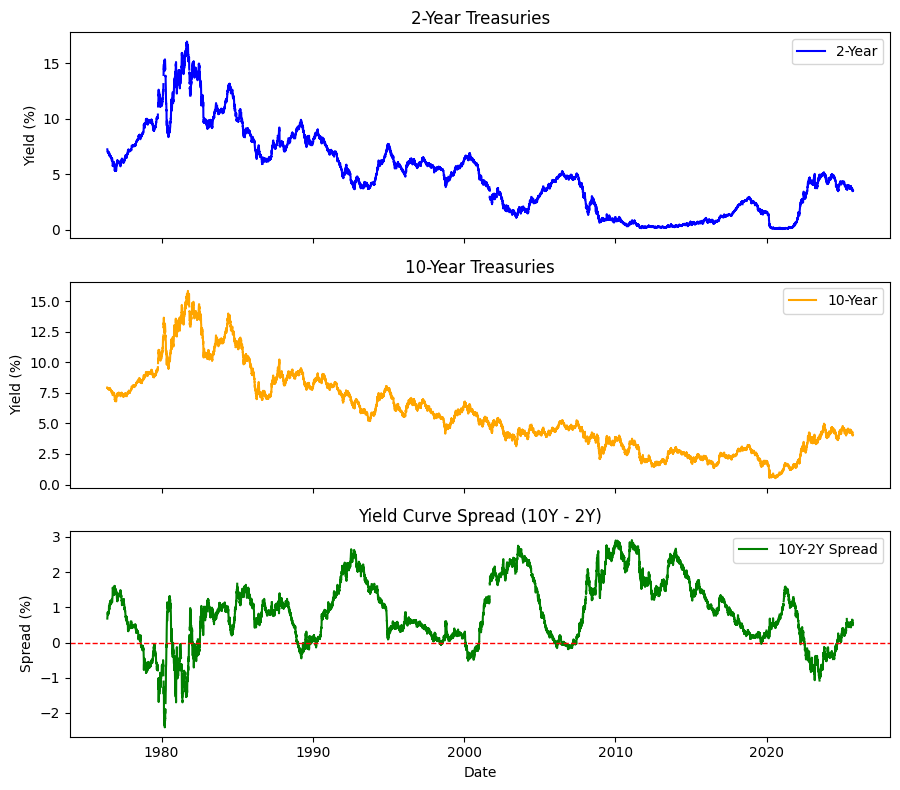

In [35]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(3, 1, figsize=(9,8), sharex=True)

# 2-Year
axes[0].plot(yields_df["date"], yields_df["DGS2"], label="2-Year", color="blue")
axes[0].set_title("2-Year Treasuries")
axes[0].set_ylabel("Yield (%)")
axes[0].legend()

# 10-Year
axes[1].plot(yields_df["date"], yields_df["DGS10"], label="10-Year", color="orange")
axes[1].set_title("10-Year Treasuries")
axes[1].set_ylabel("Yield (%)")
axes[1].legend()

# Spread (10y - 2y)
spread = yields_df["DGS10"] - yields_df["DGS2"]
axes[2].plot(yields_df["date"], spread, label="10Y-2Y Spread", color="green")
axes[2].axhline(0, color="red", linestyle="--", linewidth=1)  # zero line for inversion
axes[2].set_title("Yield Curve Spread (10Y - 2Y)")
axes[2].set_ylabel("Spread (%)")
axes[2].set_xlabel("Date")
axes[2].legend()

plt.tight_layout()
plt.show()



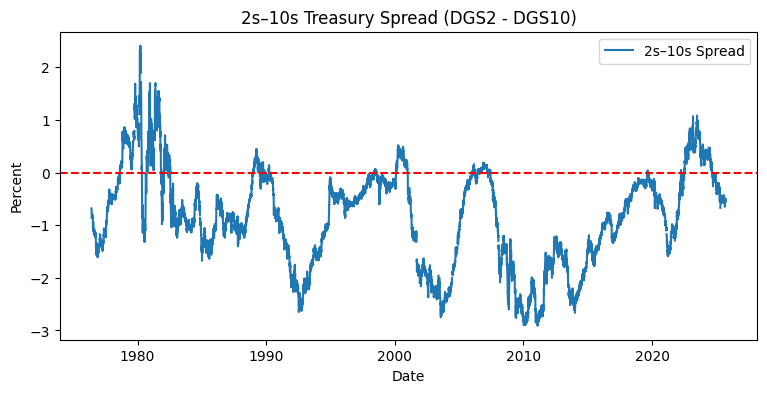

In [36]:

yields_df["spread_2s10s"] = yields_df["DGS2"] - yields_df["DGS10"]

plt.figure(figsize=(9,4))
plt.plot(yields_df["date"], yields_df["spread_2s10s"], label="2s–10s Spread")
plt.axhline(0, linestyle="--", color="red")
plt.title("2s–10s Treasury Spread (DGS2 - DGS10)")
plt.xlabel("Date"); plt.ylabel("Percent")
plt.legend()
plt.show()

Three-month spread versus 10 Year Treasury

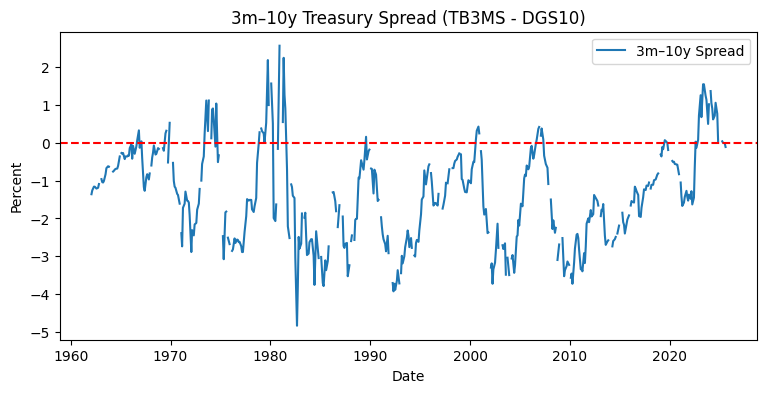

In [37]:
# Pull 3-Month Treasury Bill
tb3m = fred_series("TB3MS")   # 3-Month Treasury Bill

# Merge with the existing 10-Year yield
yields_df2 = pd.merge(tb3m, dgs10, on="date", how="inner").sort_values("date")

# Compute spread
yields_df2["spread_3m10y"] = yields_df2["TB3MS"] - yields_df2["DGS10"]

# Plot
plt.figure(figsize=(9,4))
plt.plot(yields_df2["date"], yields_df2["spread_3m10y"], label="3m–10y Spread")
plt.axhline(0, linestyle="--", color="red")
plt.title("3m–10y Treasury Spread (TB3MS - DGS10)")
plt.xlabel("Date"); plt.ylabel("Percent")
plt.legend()
plt.show()


Example Daily Curve

In [38]:
maturities = {
    "1M": "DGS1MO", "3M": "DGS3MO", "6M": "DGS6MO", "1Y": "DGS1",
    "2Y": "DGS2", "3Y": "DGS3", "5Y": "DGS5", "7Y": "DGS7",
    "10Y": "DGS10", "20Y": "DGS20", "30Y": "DGS30"
}

# Pick a date
target_date = "2024-01-02"

curve_data = {}
for label, series in maturities.items():
    df = fred_series(series, start=target_date)
    row = df[df["date"] == target_date]
    if not row.empty:
        curve_data[label] = row[series].values[0]

curve_data


{'1M': np.float64(5.55),
 '3M': np.float64(5.46),
 '6M': np.float64(5.24),
 '1Y': np.float64(4.8),
 '2Y': np.float64(4.33),
 '3Y': np.float64(4.09),
 '5Y': np.float64(3.93),
 '7Y': np.float64(3.95),
 '10Y': np.float64(3.95),
 '20Y': np.float64(4.25),
 '30Y': np.float64(4.08)}

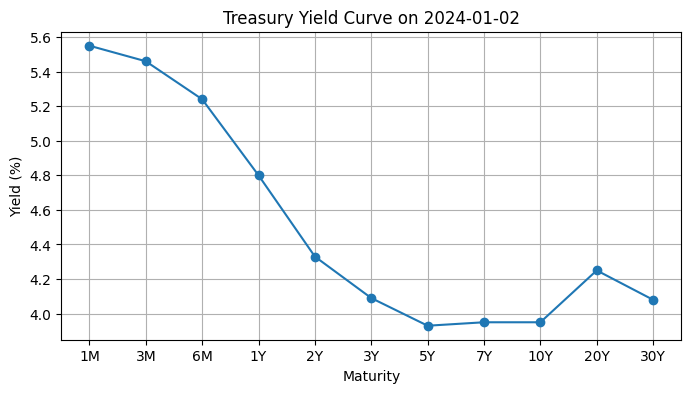

In [18]:

# Convert to ordered lists
labels = list(curve_data.keys())
yields = list(curve_data.values())

plt.figure(figsize=(8,4))
plt.plot(labels, yields, marker="o")
plt.title(f"Treasury Yield Curve on {target_date}")
plt.ylabel("Yield (%)")
plt.xlabel("Maturity")
plt.grid(True)
plt.show()


In [19]:
rec = fred_series("USREC", start="1960-01-01")

In [21]:
yields_df.sort_values(by='date')

,date,DGS2,DGS10,spread_2s10s
0,1976-06-01,7.26,7.94,-0.68
1,1976-06-02,7.23,7.94,-0.71
2,1976-06-03,7.22,7.92,-0.70
3,1976-06-04,7.12,7.89,-0.77
4,1976-06-07,7.09,7.88,-0.79
...,...,...,...,...
12857,2025-09-11,3.52,4.01,-0.49
12858,2025-09-12,3.56,4.06,-0.50
12859,2025-09-15,3.54,4.05,-0.51
12860,2025-09-16,3.51,4.04,-0.53


In [22]:
rec

,date,USREC
0,1960-01-01,0.0
1,1960-02-01,0.0
2,1960-03-01,0.0
3,1960-04-01,0.0
4,1960-05-01,1.0
...,...,...
783,2025-04-01,0.0
784,2025-05-01,0.0
785,2025-06-01,0.0
786,2025-07-01,0.0


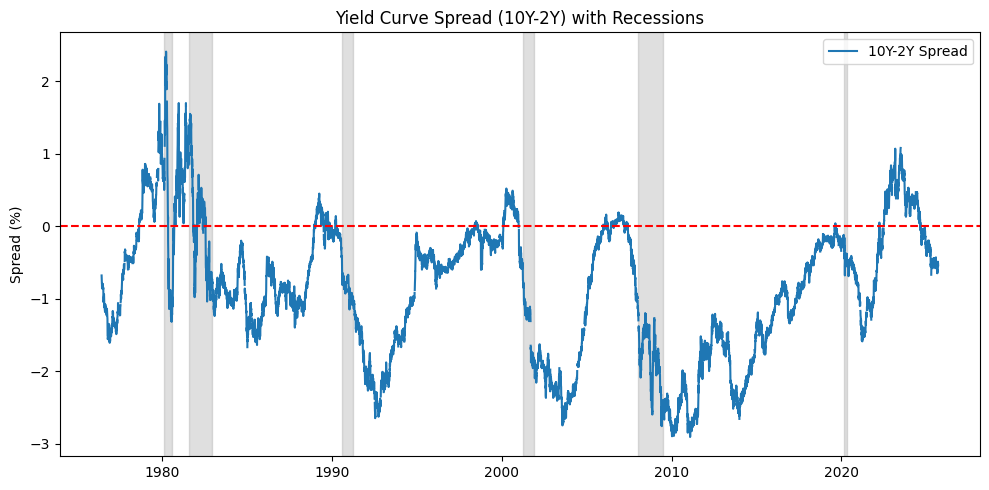

In [23]:
yields_df["date"] = pd.to_datetime(yields_df["date"])
yields_df = yields_df.set_index("date").sort_index()

# 2) Get US recessions and give it a datetime index too
rec = fred_series("USREC", start="1976-06-01")   # your helper returns a 'date' col
rec["date"] = pd.to_datetime(rec["date"])
rec = rec.set_index("date").sort_index()

# Optional: upsample to daily so shading is continuous against daily yields
rec = rec.asfreq("D").ffill()

# 3) Plot spread with recession shading
fig, ax = plt.subplots(figsize=(10,5))
ax.plot(yields_df.index, yields_df["spread_2s10s"], label="10Y-2Y Spread")
ax.axhline(0, color="red", linestyle="--")

# Find recession start/end dates from the 0/1 indicator
is_rec = rec["USREC"].astype(int)
starts = is_rec[(is_rec.shift(1, fill_value=0)==0) & (is_rec==1)].index
ends   = is_rec[(is_rec.shift(-1, fill_value=0)==0) & (is_rec==1)].index

for s, e in zip(starts, ends):
    ax.axvspan(s, e, color="gray", alpha=0.25)

ax.set_title("Yield Curve Spread (10Y-2Y) with Recessions")
ax.set_ylabel("Spread (%)")
ax.legend()
plt.tight_layout()
plt.show()